In [1]:
import cuml
import cudf
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
# from cuml import DBSCAN as cumlDBSCAN
from cuml.dask.cluster.kmeans import KMeans as daskKMeans
from cuml.decomposition import PCA
import cupy

from dask_cuda import LocalCUDACluster
import dask_cudf
from dask.distributed import Client
import dask.dataframe as dd

from cuml.dask.cluster.dbscan import DBSCAN as daskDBSCAN
# from dask_cuml.cluster import DBSCAN as daskDBSCAN

In [4]:
!python --version

Python 3.7.10


In [5]:
!pwd

/rapids/notebooks/host/transformer_attention_clustering/clustering


In [6]:
data_dir='/rapids/notebooks/host/representations/final/'

In [7]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1")
client = Client(cluster)

In [8]:
def get_pd_labels(model, dask_df):
    kmeans_labels = trained_kmeans.predict(dask_df)
    kml_computed = kmeans_labels.compute()
    return kml_computed.to_pandas()

In [9]:
def location(index):
    example = int(index/144)
    layer_head_location = index % 144
    layer = int(layer_head_location/12)
    head = layer_head_location % 12
    return (example, layer, head)

In [10]:
def layer(index):
    layer_head_location = index % 144
    return int(layer_head_location/12)
    
def head(index):
    layer_head_location = index % 144
    layer = int(layer_head_location/12)
    return layer_head_location % 12

In [11]:
def index_layer_heads(df):
    df.rename(columns={0:'cluster'},inplace=True)
    df['layer'] = (df.index.to_series().apply(layer))
    df['head'] = (df.index.to_series().apply(head))
    return df

In [15]:
# note - using 'file://' prefix: https://github.com/rapidsai/cudf/issues/3017
gdf = dask_cudf.read_csv('file://../../representations/final/full_partitions/*.csv')

In [16]:
%%time
n_clusters = 30
random_state = 0

kmeans_cuml = daskKMeans(
                       client=client,
                       init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=400,
                       random_state=random_state)

trained_kmeans = kmeans_cuml.fit(gdf)

CPU times: user 1min 3s, sys: 5.15 s, total: 1min 8s
Wall time: 17min 33s


In [17]:
#60_00.csv - 60_13.csv 7-21-20 00:31
torch.save(trained_kmeans, os.path.join(data_dir,'dask_kmeans_model_full_first_half_7_21.bin'))

In [18]:
pd_labels = get_pd_labels(trained_kmeans, gdf) #returns a pandas series

In [19]:
df_labels = pd.DataFrame(pd_labels)

In [20]:
df_labels = index_layer_heads(df_labels)

In [21]:
df_labels.head(20)

,cluster,layer,head
0,25,0,0
1,5,0,1
2,26,0,2
3,26,0,3
4,5,0,4
5,5,0,5
6,5,0,6
7,5,0,7
8,7,0,8
9,5,0,9


In [22]:
torch.save(df_labels, os.path.join(data_dir,'dask_kmeans_df_labels_full_first_half_7_21.bin'))

In [ ]:
# Load DF labels from kaggle

In [23]:
cluster_bylayer = df_labels.groupby(['cluster','layer']).count()

In [25]:
cluster_layer.tail(30)

head
cluster layer      
27      6      2095
        7      1733
        8      2099
        9      2389
        10     2425
        11     2550
28      0      2230
        1      2739
        2      1643
        3      1472
        4      1889
        5      2613
        6      2959
        7      4744
        8      3143
        9      2080
        10     1883
        11     1558
29      0      2299
        1      1960
        2      2098
        3      2919
        4      2865
        5      3287
        6      2572
        7      2918
        8      2990
        9      2176
        10     3298
        11     5207

In [26]:
cluster_layer = df_labels.groupby(['cluster','head']).count()

In [27]:
cluster_layer.tail(30)

layer
cluster head       
27      6      2019
        7      2297
        8      1995
        9      2172
        10     2246
        11     1946
28      0      2538
        1      2388
        2      1819
        3      2692
        4      2889
        5      1854
        6      2510
        7      2624
        8      2280
        9      2287
        10     2362
        11     2710
29      0      2238
        1      2160
        2      2968
        3      2785
        4      2676
        5      3562
        6      2896
        7      2609
        8      3373
        9      3036
        10     3293
        11     2993

/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

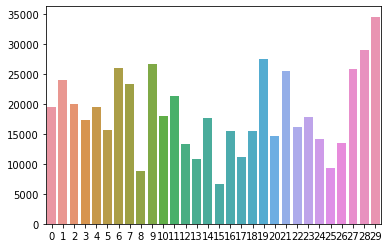

In [28]:
label_count = df_labels['cluster'].value_counts()

x = label_count.index
y = label_count.values

sns.barplot(x, y)